### Retrieve GHG emissions from forest fires

_Author_: Chiara Aquino
<br>
_Date_: 12 March 2024

This script provides the functions used to calculate GHG emissions from forest fires. GHG emissions are calculated using the model from in Chiriacò et al.(2013):

    GHG emissions = A x B x C x D x 10-3 

where: 
<br>
GHG emissions = amount of GHGs released as a result of fire [kgton of GHG]; 
<br>
A = burnt area [ha], provided by input data (EFFIS) 
<br>
B = mass of available fuels, in [kg dry matter ha-1]
<br>
C = combustion factor, portion of biomass combusted [dimensionless]
<br>
D = emission factor [g GHG kg–1] for each GHG compound. 

**Reference**
<br>
Chiriaco, M.V., Perugini, L., Cimini, D., D’Amato, E., Valentini, R., Bovio, G., Corona, P. and Barbati, A., 2013. Comparison of approaches for reporting forest fire-related biomass loss and greenhouse gas emissions in southern Europe. _International Journal of Wildland Fire_, 22(6), pp.730-738.


In [1]:
#!pip list

In [2]:
#import libraries
import geopandas
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import functools
import time
import logging
import warnings

# Suppress UserWarning
warnings.filterwarnings("ignore", category=UserWarning)
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

#### GHG functions

In [3]:
# Suppress UserWarning globally
def suppress_user_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

def timer(func):
    """
    Decorator that measures the execution time of a function.
    Logs the elapsed time.
    """
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()  # Start timer
        result = func(*args, **kwargs)
        end_time = time.perf_counter()    # End timer
        elapsed_time = end_time - start_time
        logging.info(f"Function '{func.__name__}' executed in {elapsed_time:.4f} seconds.")
        return result
    return wrapper_timer

In [4]:
@timer
def import_data(path_to_data_location, path_to_italian_regions_shapefile, crs, region=None, **kwargs):
    """
    Retrieve burnt area polygon from the shapefile and filter it based on selected columns and values.

    Parameters:
    - path_to_data_location (string) : location of the EFFIS shapefile
    - path_to_italian_regions_shapefile (string) : location of the shapefile containing Italian regions
    - crs (string) : coordinate reference system of choice
    - region (string) : name of Italian region
    - *kwargs: Optional arguments for column name and corresponding values.

    Returns:
    - pd.DataFrame: Filtered DataFrame.
    """
     #open shapefile as DataFrame
    df = geopandas.read_file(path_to_data_location)
    
    #Copy the original DataFrame
    filtered_df = df.copy()
       
    #extract year from EFFIS date column so that the DataFrame can be filtered by year only
    filtered_df['FIREDATE'] = pd.to_datetime(filtered_df['FIREDATE'], format="mixed")
    filtered_df['YEAR'] = filtered_df['FIREDATE'].dt.year
    filtered_df = filtered_df.rename(columns={"FIREDATE": "DATE"})

    for column, value in kwargs.items():
    # Check if value is declared and column exists in the DataFrame
        if value is not None:
            if column in filtered_df.columns and not filtered_df[column].empty:
                # Apply filter to DataFrame if column and value are valid
                filtered_df = filtered_df[filtered_df[column] == value]
            else:
                print(f"No data found where '{column}' is '{value}'.")
        
                
    if region: 
        italian_regions = geopandas.read_file(path_to_italian_regions_shapefile)
        italian_regions = italian_regions[italian_regions['DEN_REG'] == region]
    
        #make sure both regions and the burnt area shapefile are in the same crs
        italian_regions = italian_regions.to_crs(crs)
        filtered_df= filtered_df.to_crs(crs)

        
        #clip burnt area shapefile with italian region shapefile
        filtered_df = geopandas.clip(filtered_df,italian_regions)
    
    return filtered_df    


def get_landcover_classes(landcover, path_to_landcover_legend, language):
    """
    Retrieve landcover classes from the landcover shapefile and filter based on selected columns and values.
    
    Parameters:
    - landcover (string): name of landcover type
    - path_to_landcover_legend (string): location of landcover legend table
    - language (string): 'English' or 'Italian'
    
    Returns:
    - classes, names, colors: Lists of landcover codes, names, and colors.
    """
    landcover_legend = pd.read_csv(path_to_landcover_legend)
    language_column = f"{landcover}_NAME_{language}"
    
    valid_rows = landcover_legend[[f"{landcover}_CODE", language_column, f"{landcover}_COLOR"]].dropna()
    classes = valid_rows[f"{landcover}_CODE"].astype(str).tolist()
    names = valid_rows[language_column].tolist()
    colors = valid_rows[f"{landcover}_COLOR"].tolist()
    
    return classes, names, colors

@timer
def intersect_vectors(path_to_poly_to_overlay, poly_underneath, crs):
    """
    Filter Corine (CLC18) landcover classes by clipping Corine landcover with burnt area shapefile.

    Parameters:
    - path_to_clc18_shapefile (string): location of Corine shapefile
    - df_burnt_area_shape (pd.DataFrame): burnt area DataFrame
    - forest_classes (list of str): forest classes
    - crs (string): chosen coordinate system, e.g., "epsg:4326"

    Returns:
    - geopandas.GeoDataFrame: Corine landcover classes in burnt area.
    """
    top = geopandas.read_file(path_to_poly_to_overlay).to_crs(crs)
    underneath = poly_underneath.to_crs(crs)
    
    return geopandas.overlay(top, underneath, how="intersection")


def get_biomass(path_to_lookup_table, path_to_biomass_table, landcover, region=None):
    """
    Retrieve pre disturbance biomass for each vegetation type
    Data is derived from average standing volume estimates from National Forest Inventory 2015 (INFC2015). INFC2015 classes have been 
    averaged for each of the 20 Italian administrative regions to match EFFIS or CLC18 vegetation classes

    Parameters:
    - path_to_lookup_table (str) : location of lookup tables for different landcover classes -> INFC2015 classes
    - path_to_biomass_table (str) : location of National Forest Inventory 2015 biomass values, per vegetation type, per each Italian region 
    - landcover (str) : landcover type to use (CLC18 or EFFIS)
    - region (str): Italian region of interest. Default region is None. 
    
    Returns:
    - pd.DataFrame: Processed DataFrame with average biomass values and standard deviation per selected region per vegetation class
    """
    lookup = pd.read_csv(path_to_lookup_table)
    biomass = pd.read_csv(path_to_biomass_table)

    # Drop the first row from the biomass table, as this contains forest types as strings (not needed)
    biomass = biomass.iloc[1:]

    #Ensure all columns after the first are float numbers
    biomass.iloc[:, 1:] = biomass.iloc[:, 1:].astype(float)

    #Transform all 0s in NANs 
    biomass = biomass.replace(0, np.nan)

    # Tidy up INFC biomass data so we can merge with lookup table
    biomass = biomass.T
    biomass.columns = biomass.iloc[0]
    biomass = biomass.drop(biomass.index[0])
    # Make the index a regular column and rename columns
    biomass = biomass.reset_index().rename(columns={'index': 'INFC_ID'})

    # Make sure that the INFC codes are integer columns, so we can correctly match them from the two tables
    lookup['INFC_ID'] = lookup['INFC_ID'].astype(int)
    biomass['INFC_ID'] = biomass['INFC_ID'].astype(int)

    # From the lookup table, select only data for the landcover type we are using
    lookup = lookup[[landcover+"_CLASS","INFC_ID"]]

    # get biomass calculation by landcover type
    # 1) merge the two dataframes on common "INFC_Code" (ie, vegetation classes from INFC)
    biomass_by_landcover = pd.merge(lookup, biomass, on='INFC_ID')

    # Drop duplicate rows and sort table by landcover class and vegetation ID
    biomass_by_landcover = biomass_by_landcover.drop_duplicates().sort_values(by=[landcover+"_CLASS","INFC_ID"])

    #make sure the code is a string, so that we can use it later
    biomass_by_landcover[landcover+"_CLASS"] = biomass_by_landcover[landcover+"_CLASS"].astype(str)

    # 2) take average of values for each region grouped by landcover class
    # pandas skips Nan values by default
    grouped = biomass_by_landcover.groupby([landcover+"_CLASS"]).mean()
    grouped_uncertainity = biomass_by_landcover.groupby([landcover+"_CLASS"]).sem()

    #3) calculate biomass for the region selected (default is None)
    # if region is specified, then select the column containing values for that region
    if region is not None:
        biomass_by_region = grouped[region]
        biomass_uncertainty_by_region = grouped_uncertainity[region]
    
    # if region is not specified (if region left as None) get average values for Italy
    else:
        biomass_by_region = grouped['Italia']
        biomass_uncertainty_by_region = grouped_uncertainity['Italia']

    # return biomass dataframe for use in GHG equation
    df_biomass = pd.DataFrame(biomass_by_region)
    df_biomass = df_biomass.reset_index()
    df_biomass = df_biomass.rename(columns={landcover+'_CLASS':landcover, region: 'BIOMASS'})

     # return uncertainty biomass dataframe for use in GHG equation
    df_biomass_uncertainty = pd.DataFrame(biomass_uncertainty_by_region)
    df_biomass_uncertainty = df_biomass_uncertainty.reset_index()
    df_biomass_uncertainty = df_biomass_uncertainty.rename(columns={landcover+'_CLASS':landcover,region: 'BIOMASS_STD'})
    df_biomass_uncertainty = df_biomass_uncertainty.replace(np.nan, 0)
    
    # merge biomass and its uncertainities in one table
    df_biomass = pd.merge(df_biomass,df_biomass_uncertainty,on=landcover)

    df_biomass[landcover] = df_biomass[landcover].astype(int)

    
    return df_biomass


def get_combustion_factor(path_to_fire_severity_shapefile, forest_in_burnt_area, 
                          path_to_forest_classes, path_to_C_factor_table, landcover, crs):


    """
    Retrieve combustion factor for each forest type in each burn area.
    These value are retrieved from an empirical combustion model by Aquino et al. (202X)

    Parameters:
    - path_to_fire_severity_shapefile (str) : location of the fire severity shapefile (converted from raster from the original by EFFIS)
    - forest_in_burnt_area (pd.DataFrame) : geodataframe with the landcover forest classes in burnt area
    - path_to_forest_classes (str) : location of the lookup tables between CLC18 landcover and forest types
    - path_to_C_factor_table: location of the combustion factor table per forest type
    - landcover (str) : landcover type to use (eg CLC18)
    - crs (str) : coordinate reference system

    Returns:
    - pd.DataFrame: Processed DataFrame with combustion factor values per vegetation type AND area 
    """
    
    fire_severity = intersect_vectors(path_to_fire_severity_shapefile, forest_in_burnt_area, crs)
    
    fire_severity.rename(columns={'value': 'fire_severity'}, inplace=True)
    # remove empty values of fire severity
    fire_severity = fire_severity.dropna(subset=['fire_severity'])
    # remove values of fire severity == 1 (unburnt)
    fire_severity = fire_severity [fire_severity ['fire_severity'] != 1]
    fire_severity = fire_severity [fire_severity ['fire_severity'] != 0]

    forest_lookup = pd.read_csv(path_to_forest_classes)
    C_model = pd.read_csv(path_to_C_factor_table)

    forest_lookup[landcover+'_CLASS'] = forest_lookup[landcover+'_CLASS'].astype(int)
    forest_lookup = forest_lookup[[landcover+'_CLASS', 'FOREST_TYPE']] 
    fire_severity[landcover] = fire_severity[landcover].astype(int)

    forest_lookup = forest_lookup.drop_duplicates()
    merged = fire_severity.merge(forest_lookup, left_on=landcover, right_on=landcover+'_CLASS', how='left')

    merged_C = pd.merge(merged,C_model, left_on=['FOREST_TYPE', 'fire_severity'], right_on=['Forest_Type', 'EFFIS_Severity_Class'], how='left')
    merged_C = merged_C.drop(columns=['Forest_Type', 'EFFIS_Severity_Class', 'Severity_Class'])

    #get area
    merged_C = merged_C.to_crs({'proj':'cea'})
    merged_C["AREA_HA"] = merged_C.geometry.area / 10000
    
    return merged_C

def get_emission_factors(path_to_emission_factor_table):

    """
    Retrieve emission factor table containing each GHG compound and its uncertainity

    Parameters:
    - path_to_emission_factor_table (str) : location of emission factor table (IPCC,2006)

    Returns:
    - pd.DataFrame: DataFrame with emission factor values per GHG compound
    """

    df_emission_factors = pd.read_csv(path_to_emission_factor_table)
    return df_emission_factors
    
    
def get_total_ghg_emissions(AC,B,D,landcover):
    """

    This function puts together all the previous steps of the model and calculates final GHG emissions. 
    
    Parameters: 
    - AC (pd.DataFrame) : burnt area and combustion factor for each vegetation type, as retrieved by function get_combustion_factor() 
    - B (pd.DataFrame) : pre disturbance biomass for each vegetation type, as retrived by function get_biomass()
    - D (pd.DataFrame) : emission factor for each GHG, as retrieved by function get_emission_factors()
    - landcover (str) : landcover type to use (CLC18 or EFFIS)

    Returns:
    - Float: total_ghg_kton (total GHG emissions in kton)
    - Float: total_ghg_kton_std (standard deviation of total GHG emissions in kton)
    - pd.Dataframe: ABCD (GHG emissions by forest class)

    """
    
    #Merge A,B,C and D DataFrames on the 'landcover' column
    ABC = AC.merge(B, on=landcover, how='inner')
    ABCD = ABC.merge(D, how='cross')

    #for the biomass values replace nan with 0
    #ABCD = ABCD.dropna(subset=['BIOMASS'])
    ABCD = ABCD.fillna(0)
    
    gases = ['CO2','CH4','CO','N2O','NOx']

    # calculate emissions and standard deviation for each gas, according to the model formula
    for gas in gases:
        ABCD[gas+'_MG'] = (1e-3 * ABCD['AREA_HA'] * ABCD['BIOMASS'] * ABCD['COMBUSTION_FACTOR']* ABCD[gas]).astype(float)
    
        ABCD[gas+'_STD_MG'] = (1e-3 * ABCD[gas+'_MG'] * ((ABCD['BIOMASS_STD'] / ABCD['BIOMASS'] if ['BIOMASS'] != 0 else 0)**2 
                                                         + (ABCD['COMBUSTION_FACTOR_STD'] / ABCD['COMBUSTION_FACTOR'] if ['COMBUSTION_FACTOR'] != 0 else 0)**2
                                                        + (ABCD[gas+'_STD'] / ABCD[gas])**2)**0.5).astype(float)
    
    
    # apply conversion factor for N2O e CH4, to convert into CO2eq
    ABCD['N2OEQ_MG'] = ABCD['N2O_MG'] * 273
    ABCD['N2OEQ_STD_MG'] = 273 * ABCD['N2OEQ_MG'] * (ABCD['N2O_STD_MG'] / ABCD['N2O_MG'])
    
    ABCD['CH4EQ_MG'] = ABCD['CH4_MG'] * 28
    ABCD['CH4EQ_STD_MG'] = 28 * ABCD['CH4EQ_MG'] * (ABCD['CH4_STD_MG'] / ABCD['CH4_MG'])
    
    ABCD['TOTEQ_MG'] = ABCD['CO2_MG'] + ABCD['CH4EQ_MG'] + ABCD['N2OEQ_MG']
    ABCD['TOTEQ_STD_MG'] = (ABCD['CO2_STD_MG'] ** 2 + ABCD['CH4EQ_STD_MG'] ** 2 + ABCD['N2OEQ_STD_MG'] ** 2) ** 0.5
    
    #get total emissions in kton
    total_ghg_kton = ABCD['TOTEQ_MG'].sum() /1000
    
    #Calculate error over the sum using error propagation
    error_squared = (ABCD['TOTEQ_STD_MG'] ** 2).sum()
    error_over_sum = np.sqrt(error_squared) 
    total_ghg_kton_std = error_over_sum/1000

    
    return total_ghg_kton,total_ghg_kton_std, ABCD

@timer
def plot_and_save(forest_classes, forest_labels, forest_colors, 
                                       path_to_italian_regions_shapefile,region,
                                       language,df_burnt_shape,df,crs, path_to_table_output=None,
                                       path_to_shapefile_output=None,plot_region=False):
    """
    This function creates: 1) plot of the burnt area and forest classes within it
                           2) bar plot of GHG emissions for each forest class
                           3) table with total GHG emissions per class (to save)
                           4) shapefile with perimeters of forest classes and emissions (to save)
    
    Parameters: 
    - forest_classes, forest_label, forest_colors(list) : list of names of all forest classes, labels and colors
    - path_to_italian_region_shapefile (str) : location of italian region shapefile
    - region (str) : name of region
    - language (string) : if 'English' or 'Italian' 
    - df_burnt_shape (pd.DataFrame): input DataFrame containing burnt area for the fire event
    - df (pd.DataFrame) : GHG emissions by each forest type, as outputted by get_total_ghg_emissions() function
    - crs (str) : coordinate reference system
    - path_to_table_output (str): path to location where to save csv table of land cover classes with GHG emissions (Default is None)
    - path_to_shapefile_output (str): path to location where to save shapefile of land cover classes with GHG emissions (Default is None)
    - plot_region (bool): if plotting region shapefile (Default is False)
    

    Returns:
    - None
    """
    
    import matplotlib.cm as cm
    # create dataframe for plotting
    df_plot = pd.DataFrame(
    {'_CLASS': forest_classes,
     '_LABEL': forest_labels,
     '_COLOR': forest_colors
    })
    
    df= df[['CLC18', "geometry",
           'AREA_HA', 'FOREST_TYPE', 'COMBUSTION_FACTOR', 'COMBUSTION_FACTOR_STD',
           'BIOMASS', 'BIOMASS_STD', 'CO2_MG', 'CO2_STD_MG', 'CH4EQ_MG', 'CH4EQ_STD_MG', 
            'N2OEQ_MG', 'N2OEQ_STD_MG', 'TOTEQ_MG','TOTEQ_STD_MG']]
    
    
    # convert std to variance so that they can be summed
    df['TOTEQ_VAR_MG'] = df['TOTEQ_STD_MG'] ** 2
    df['CO2_VAR_MG'] = df['CO2_STD_MG'] ** 2
    df['CH4EQ_VAR_MG'] = df['CH4EQ_STD_MG'] ** 2
    df['N2OEQ_VAR_MG'] = df['N2OEQ_STD_MG'] ** 2
    
    # dissolve geometry on landcover classes
    lc = df.dissolve(by=landcover, aggfunc={'AREA_HA' : 'sum',
        'TOTEQ_MG': 'sum',  'TOTEQ_VAR_MG': 'sum', 'CO2_MG' :'sum', 'CO2_VAR_MG':'sum',
        'CH4EQ_MG':'sum', 'CH4EQ_VAR_MG':'sum', 'N2OEQ_MG'  :'sum', 'N2OEQ_VAR_MG'  :'sum'      
    })
    
    # convert variance back to standard deviation
    lc['TOTEQ_STD_MG'] = np.sqrt(lc['TOTEQ_VAR_MG'])
    lc['CO2_STD_MG'] = np.sqrt(lc['CO2_VAR_MG'])
    lc['CH4EQ_STD_MG'] = np.sqrt(lc['CH4EQ_VAR_MG'])
    lc['N2OEQ_STD_MG'] = np.sqrt(lc['N2OEQ_VAR_MG'])
    
    lc = lc.reset_index()
    
    #make sure landcover is in string format in both tables
    df_plot['_CLASS'] = df_plot['_CLASS'].astype(str)
    lc[landcover] = lc[landcover].astype(str)
    
    #make sure landcover and burnt area are in the same CRS
    lc = lc.to_crs(crs)
    df_burnt_shape = df_burnt_shape.to_crs(crs)
    
    ghg_in_lc_plot = pd.merge(lc,df_plot, left_on=landcover,right_on="_CLASS", how="inner")
    ghg_in_lc_plot["CLASS_LABEL"] = ghg_in_lc_plot["_CLASS"] + " - " + ghg_in_lc_plot["_LABEL"]

    # PLOT1: BURNT AREA
    if df_burnt_shape.empty or ghg_in_lc_plot.empty:
        print("Cannote plot empty shapefile.")
    else:
        if plot_region:
            fig, axs = plt.subplots(figsize=(8, 5))
            italian_regions = geopandas.read_file(path_to_italian_regions_shapefile)
            italian_regions = italian_regions.to_crs(crs)
            italian_regions = italian_regions[italian_regions['DEN_REG'] == region]
            italian_regions.plot(ax=axs, facecolor='none', edgecolor='blue', linewidth=1)  
            #plot burnt shape
            df_burnt_shape.plot(ax=axs, facecolor='none', edgecolor='red', linewidth=1)  
            #plot land cover classes
            ghg_in_lc_plot.plot(ax=axs, label=ghg_in_lc_plot._LABEL, color=ghg_in_lc_plot._COLOR,legend=True)
        else:
            fig, axs = plt.subplots(figsize=(8, 5))
            #plot burnt shape
            df_burnt_shape.plot(ax=axs, facecolor='none', edgecolor='red', linewidth=1)  
            #plot land cover classes
            ghg_in_lc_plot.plot(ax=axs, label=ghg_in_lc_plot._LABEL, color=ghg_in_lc_plot._COLOR,legend=True)
    
        shapes = []
        lab =[]
            
        #Create legend patches
        for color, label, ghg, ghg_std, fclass in zip(ghg_in_lc_plot._COLOR,ghg_in_lc_plot.CLASS_LABEL,
                                                      ghg_in_lc_plot.TOTEQ_MG, ghg_in_lc_plot.TOTEQ_STD_MG, ghg_in_lc_plot._CLASS):
             p = matplotlib.patches.Patch(facecolor=color, edgecolor='gray')
             l = label +" - " + str(np.round(ghg/1000,2)) + " ktonnes CO2eq"
             shapes.append(p)
             lab.append(l)
            
        #create legend, by first getting the already present handles, labels
        handles, labels = plt.gca().get_legend_handles_labels()
        
        #and then adding the new ones
        handles.extend(shapes)
        labels.extend(lab)
        
        by_label = dict(zip(labels, handles))
    
        #plot legend
        axs.legend(by_label.values(), by_label.keys(), framealpha=1.,fontsize="medium",bbox_to_anchor=(0.5, -0.4), loc='center', ncol=1)
    
        plt.show()


    # PLOT2: BARPLOT
    num_classes = len(ghg_in_lc_plot["_LABEL"])
    colors = cm.turbo(np.linspace(0, 1, num_classes))

    fig, ax = plt.subplots(figsize=(7, 6))
    ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
    plt.bar(ghg_in_lc_plot["_LABEL"], ghg_in_lc_plot['TOTEQ_MG']/1000, color=colors)
    #plt.xlabel('CLC18 Class')
    plt.ylabel('Total GHG (ktonnes)')
    plt.title('Total GHG emissions per forest type')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.tight_layout()
    plt.show()

    #Tidy up before saving
    ghg_in_lc_plot= ghg_in_lc_plot[['CLC18', '_CLASS', '_LABEL',
           'AREA_HA', 'CO2_MG', 'CO2_STD_MG', 'CH4EQ_MG', 'CH4EQ_STD_MG', 
            'N2OEQ_MG', 'N2OEQ_STD_MG', 'TOTEQ_MG','TOTEQ_STD_MG', 'geometry']]
    
    if path_to_shapefile_output:
            ghg_in_lc_plot.to_file(path_to_shapefile_output)
            print(f"GHG per forest type shapefile save to '{path_to_shapefile_output}'")

    ghg_in_lc_plot = ghg_in_lc_plot.drop(columns='geometry')
    
    if path_to_table_output:
            ghg_in_lc_plot.to_excel(path_to_table_output)
            print(f"GHG per forest type table save to '{path_to_table_output}'")





#### Input parameters

2024-10-30 14:49:43,664 - INFO - Function 'import_data' executed in 1.3743 seconds.


total burn events: 49


2024-10-30 14:49:51,096 - INFO - Function 'intersect_vectors' executed in 7.4204 seconds.
2024-10-30 14:50:02,436 - INFO - Function 'intersect_vectors' executed in 11.3343 seconds.


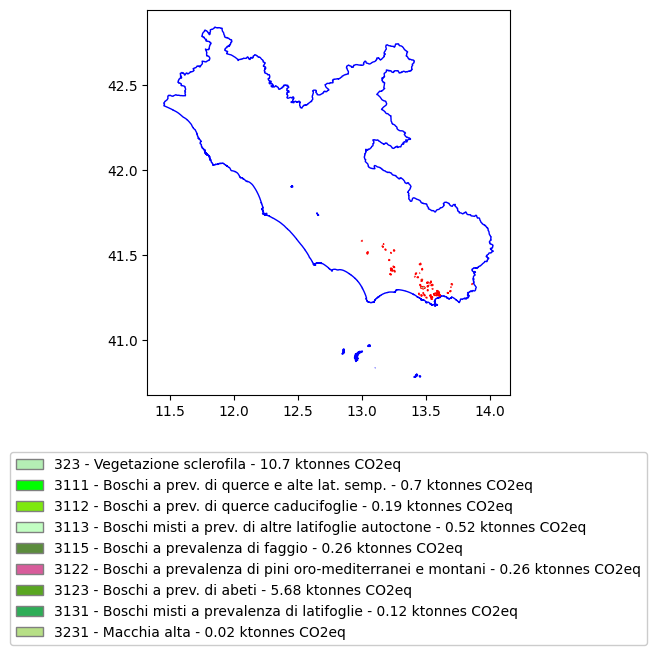

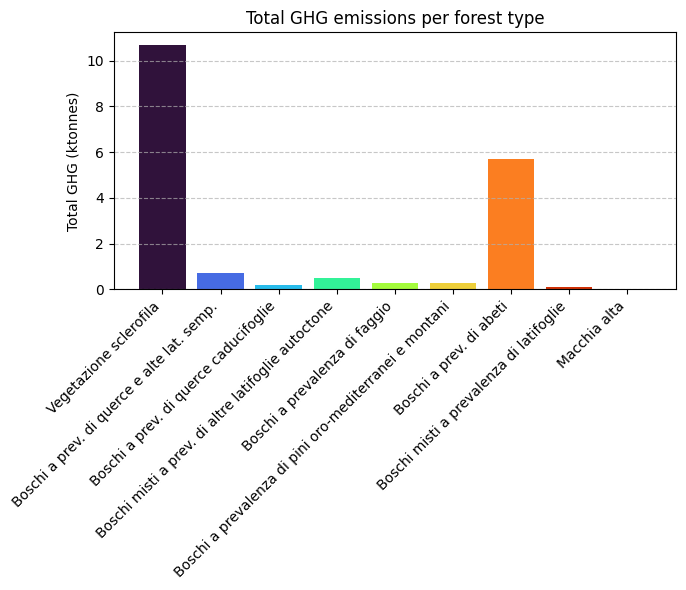

2024-10-30 14:50:04,064 - INFO - Created 9 records


GHG per forest type shapefile save to '../outputs/tests/Lazio_2022_GHG_emissions_by_forest_type.shp'


2024-10-30 14:50:04,959 - INFO - Function 'plot_and_save' executed in 2.3504 seconds.
2024-10-30 14:50:04,959 - INFO - Function 'main' executed in 22.6618 seconds.


GHG per forest type table save to '../outputs/tests/Lazio_2022_GHG_emissions_by_forest_type.xlsx'

 total GHG emissions for the year 2022 in Lazio region in 18.45 +/- 0.06 ktonnes CO2eq


In [8]:
landcover="CLC18"

ID = None
country = "IT" 
region = "Lazio"
province = "Latina"
commune = None
language = "ITALIAN"
year = 2022
crs = "epsg:4326"

path_to_fire_severity_shapefile = "../data/shapefiles/fire_severity/severity_"+str(year)+"_italy.shp"
path_to_effis_shapefile = '../data/shapefiles/effis/effis_italy_fixed_4326_10092024.shp'
path_to_it_regions_shapefile = '../data/shapefiles/ItalianRegions/Reg01012023_WGS84.shp'
path_to_clc18_shapefile = "../data/shapefiles/CORINE_LC18/CLC18_IVLIV_IT_FOREST_CLASSES_fixed.shp"
path_to_landcover_legend_table = "../data/tables/FOREST_LANDCOVER_LEGEND.csv"
path_to_C_factor_table = "../data/tables/FIRE_SEVERITY_C_FACTOR_EMPIRICAL_MODEL.csv"
path_to_forest_classes_table = "../data/tables/FOREST_CLASSES_LOOKUP.csv"
path_to_combustion_factor_table = "../data/tables/FIRE_SEVERITY_C_FACTOR_EMPIRICAL_MODEL.csv"
path_to_biomass_table = "../data/tables/INFC15_AGB_PER_REGION.csv"
path_to_emission_factors_table = "../data/tables/GHG_EMISSION_FACTORS.csv"
path_to_shapefile_output = "../outputs/tests/"+region+"_"+str(year)+"_GHG_emissions_by_forest_type.shp"
path_to_table_output = "../outputs/tests/"+region+"_"+str(year)+"_GHG_emissions_by_forest_type.xlsx"


@timer
def main():
    warnings.filterwarnings('ignore')
    
    # Step 1: Import Data
    burnt_shape = import_data(path_to_effis_shapefile,path_to_it_regions_shapefile,crs,region,COUNTRY=country,COMMUNE=commune,
                              PROVINCE=province,YEAR=year)
    print("total burn events:", len(burnt_shape))
    
    # Step 2: Get Landcover Classes
    forest_classes, forest_labels, forest_colors = get_landcover_classes(landcover,path_to_landcover_legend_table,language)
        # get landcover class within burnt area
    forest_in_burnt_area = intersect_vectors(path_to_clc18_shapefile, burnt_shape, crs)
    
    # Step 3: Calculate Total Burnt Area
    AC = get_combustion_factor(path_to_fire_severity_shapefile, forest_in_burnt_area, 
                          path_to_forest_classes_table, path_to_C_factor_table, landcover, crs)
    
    #Step 4: Calculate biomass
    B = get_biomass(path_to_forest_classes_table, path_to_biomass_table, landcover, region)

    # Step 5. Get combustion factor (C) for each vegetation type
    D = get_emission_factors(path_to_emission_factors_table)
        
    # Step 7. Calculate total GHG emissions from emission factors
    ghg, ghg_std, ghg_all_events = get_total_ghg_emissions(AC,B,D,landcover)

    #plot 
    plot_and_save(forest_classes, forest_labels, forest_colors, 
                                       path_to_it_regions_shapefile,region,
                                       language,burnt_shape,ghg_all_events,crs,path_to_table_output,
                                       path_to_shapefile_output,plot_region=True)

    # Return results if needed
    return ghg, ghg_std, ghg_all_events

if __name__ == "__main__":
    ghg, ghg_std, ghg_all_events = main()

#check Total GHG per year
print("\n total GHG emissions for the year " + str(year)  +" in " + str(region) +" region in "
      + str(np.round(ghg,2))+ " +/- " + str(np.round(ghg_std,2))+ " ktonnes CO2eq")